In [3]:
### Load libraries and data ###

import pandas as pd
import pickle

synthetic_df = pd.read_csv('synthetic_data.csv')
original_df = pd.read_csv('WEB_TARGET.csv')


### Multiclass Classification of 6 month occlusion '6_mo_occ'

In [4]:
original_df.columns

Index(['Age', 'Sex', 'Ruptured', 'Circulation', 'Location', 'Ignore',
       'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
       'Other diameter', 'Neck (mm) orthogonal view 1',
       'Neck (mm) orthogonal view 2', 'Avg neck vol', 'Aneurysm 3D Volume',
       'WEB_1_Name', 'SL/Elongated', 'WEB_1_width', 'WEB_1_Height',
       'WEB Volume', 'WEB Device #2 name', 'WEB 2 Volume', 'Final WEB Volume',
       'Comments on why a second device needed',
       'Complete WEB failure/abandonment', 'Re-sizing required',
       'Stenting used to support WEB?', 'Composite outcome',
       'Procedure related ischemic stroke?', 'Intraop rupture', '3_mo_occ',
       '6_mo_occ', '1_year_occ', 'Dual_length'],
      dtype='object')

In [5]:
synthetic_df.shape

(1000, 20)

In [6]:
synthetic_df.dtypes

Age                                   float64
Sex                                     int64
Ruptured                                int64
Circulation                             int64
Max diameter in any dimension (mm)    float64
Height (mm)                           float64
Width (mm)                            float64
Neck (mm) orthogonal view 1           float64
Neck (mm) orthogonal view 2           float64
Avg neck vol                          float64
Aneurysm 3D Volume                    float64
SL/Elongated                            int64
Final WEB Volume                      float64
Complete WEB failure/abandonment        int64
Re-sizing required                      int64
Stenting used to support WEB?           int64
Composite outcome                       int64
Procedure related ischemic stroke?      int64
Intraop rupture                         int64
6_mo_occ                                int64
dtype: object

## Re-run and save models

C:\Users\shrin\AppData\Local\Temp\ipykernel_15116\2184431774.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test.mean(), inplace=True)
c:\Users\shrin\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\shrin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Random Forest...
Training XGBoost...


c:\Users\shrin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


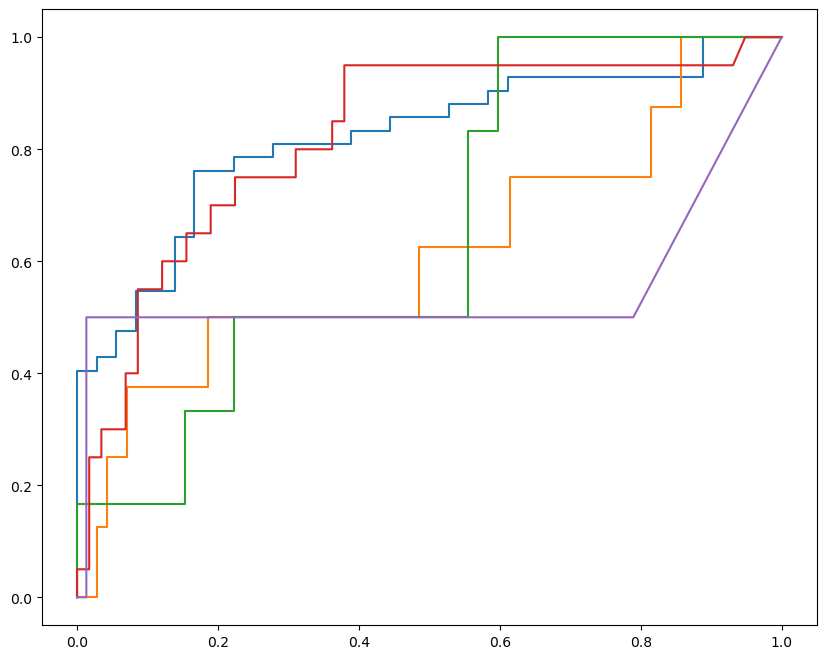

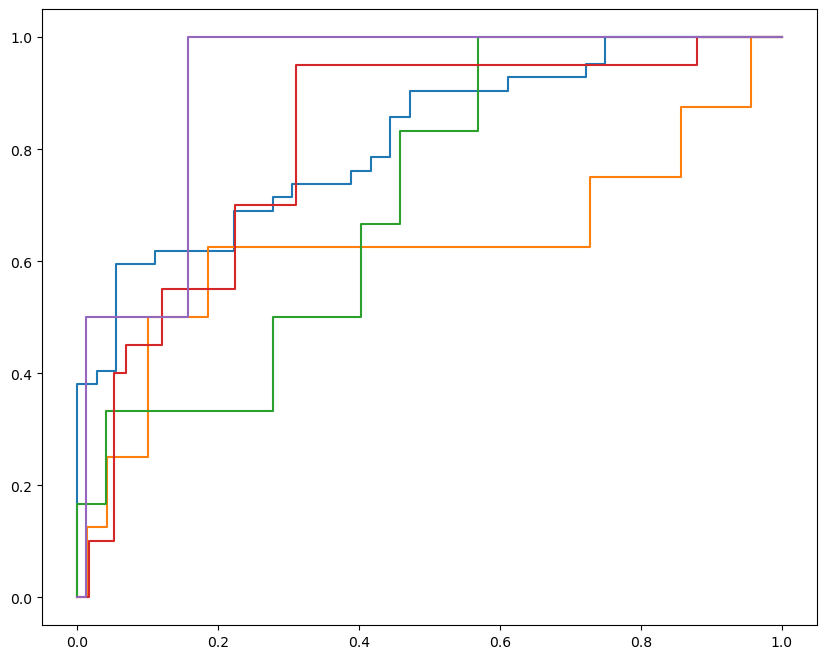

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Define features and target
features = [
    'Age', 'Sex', 'Ruptured', 'Circulation',
    'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
    'Neck (mm) orthogonal view 1', 'Neck (mm) orthogonal view 2',
    'Avg neck vol', 'Aneurysm 3D Volume', 'SL/Elongated', 'Final WEB Volume',
    'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Composite outcome',
    'Procedure related ischemic stroke?', 'Intraop rupture'
]
target = '6_mo_occ'

# Use the entire synthetic dataset
X = synthetic_df[features]
y = synthetic_df[target]

# Prepare original dataset for testing
X_test = original_df[features]
y_test = original_df[target]

X_test.fillna(X_test.mean(), inplace=True)

# Define parameter grids for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform grid search for Random Forest
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='roc_auc_ovr', 
    n_jobs=-1
)
grid_search_rf.fit(X, y)
best_rf = grid_search_rf.best_estimator_

# Perform grid search for XGBoost
grid_search_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
    param_grid_xgb, 
    cv=5, 
    scoring='roc_auc_ovr', 
    n_jobs=-1
)
grid_search_xgb.fit(X, y)
best_xgb = grid_search_xgb.best_estimator_

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train models with best hyperparameters
models = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X, y)  
    
    y_test_proba = model.predict_proba(X_test)
    
    class_aucs = {}
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(y_test):
        y_test_binary = (y_test == class_label).astype(int)
        
        fpr, tpr, _ = roc_curve(y_test_binary, y_test_proba[:, class_label])
        roc_auc = auc(fpr, tpr)
        class_aucs[class_label] = roc_auc
        
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    


In [8]:
import pickle
# save best model

import pickle

with open('best_xgb_model.pkl', 'wb') as file: 
    pickle.dump(best_xgb, file)

print("Best XGBoost model saved as 'best_xgb_model.pkl'")

with open('best_rf_model.pkl', 'wb') as file: 
    pickle.dump(best_rf, file)

print("Best Random Forest model saved as 'best_rf_model.pkl'")



Best XGBoost model saved as 'best_xgb_model.pkl'
Best Random Forest model saved as 'best_rf_model.pkl'


## Interaction Effects, PDP plots, Permutation Importance

In [15]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from itertools import combinations
from tqdm import tqdm
from modules.h_statistic import calculate_h_statistic

# Calculate H-statistics for all feature pairs
interaction_results = []
for feature_1, feature_2 in tqdm(combinations(features, 2), desc="Calculating H-statistics"):
    h_stat = calculate_h_statistic(model, X_test, feature_1, feature_2)
    interaction_results.append({
        'Feature 1': feature_1,
        'Feature 2': feature_2,
        'H-Statistic': h_stat
    })


interaction_df = pd.DataFrame(interaction_results)
interaction_df = interaction_df.sort_values(by='H-Statistic', ascending=False)


Calculating H-statistics: 158it [00:03, 40.66it/s]c:\Users\shrin\Downloads\WEB\WEB_device_failure\modules\h_statistic.py:27: RuntimeWarning: invalid value encountered in scalar divide
  h_statistic = np.var(interaction_effect) / np.var(joint_effect)
Calculating H-statistics: 171it [00:04, 39.51it/s]


In [21]:
print(interaction_df.head(30)) # Display top interactions

                              Feature 1                           Feature 2  \
128                        Avg neck vol                    Final WEB Volume   
106         Neck (mm) orthogonal view 1                        Avg neck vol   
162                  Re-sizing required                   Composite outcome   
116         Neck (mm) orthogonal view 2                        Avg neck vol   
109         Neck (mm) orthogonal view 1                    Final WEB Volume   
9                                   Age                  Aneurysm 3D Volume   
94                           Width (mm)         Neck (mm) orthogonal view 2   
11                                  Age                    Final WEB Volume   
126                        Avg neck vol                  Aneurysm 3D Volume   
83                          Height (mm)                        Avg neck vol   
66   Max diameter in any dimension (mm)                         Height (mm)   
3                                   Age  Max diamete

H-statistic (Interaction Strength) between ['Aneurysm 3D Volume', 'Age']: 0.1188


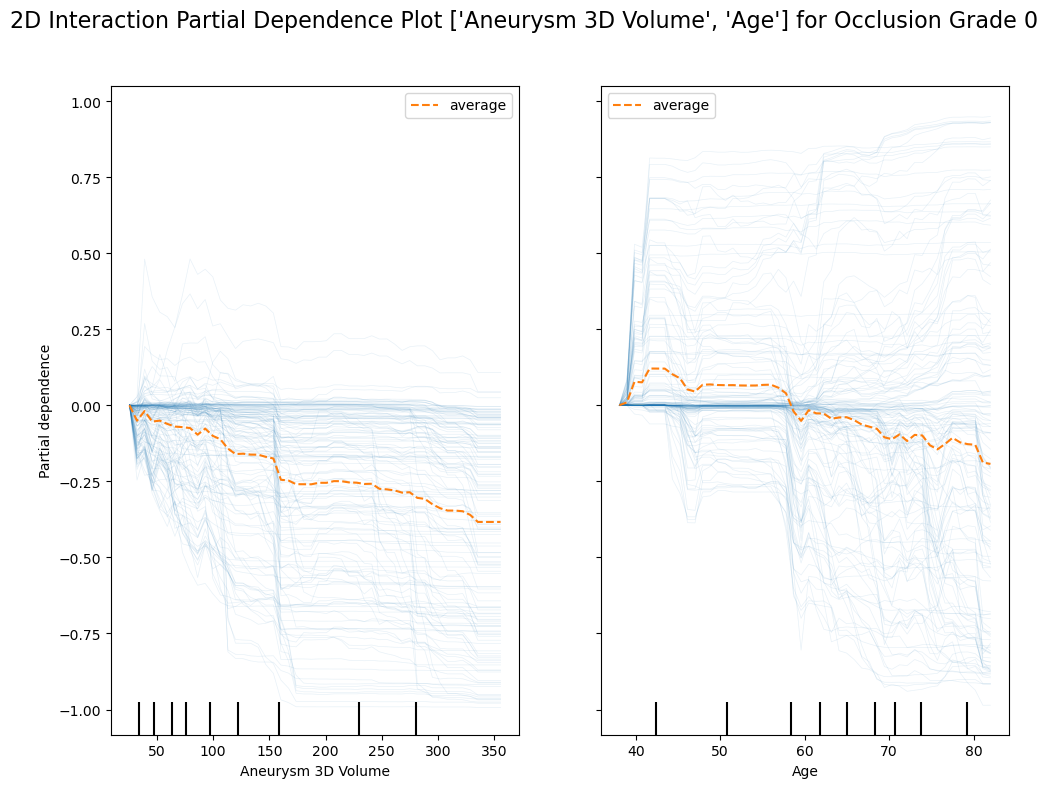

In [12]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import matplotlib.pyplot as plt
import numpy as np

model = models['XGBoost']  # or 'Random Forest' for Random Forest model

interaction_features = ['Aneurysm 3D Volume', 'Age'] # select two interaction features (e.g., ['Avg neck vol', 'Final WEB Volume'])

target_class = 0 # change the target BOSS grade [0, 4]

# ICE plot
n_samples = 150  
alpha = 0.1  

# 2D interaction Partial Dependence Plot (with c-ICE)
fig, ax = plt.subplots(figsize=(10, 8))
display = PartialDependenceDisplay.from_estimator(
    model,
    X,  # synthetic data (alternatively use X_test for original data)
    interaction_features,  
    target=target_class,  
    kind="both",  
    grid_resolution=50,  
    ice_lines_kw={'alpha': alpha},  # ICE lines
    centered=True,  # ICE plots
    n_jobs=-1,  
    subsample=n_samples,  
    ax=ax
)

# Extract Partial Dependence Values
pdp_result = partial_dependence(
    model,
    X, # synthetic data (alternatively use X_test for original data)
    features=interaction_features,
    grid_resolution=50
)

pdp_values = pdp_result.average  
feature_values = pdp_result.values 

#  H-statistic
pdp_interaction = pdp_values
pdp_1 = np.mean(pdp_interaction, axis=1, keepdims=True)
pdp_2 = np.mean(pdp_interaction, axis=0, keepdims=True)
pdp_no_interaction = pdp_1 + pdp_2 - np.mean(pdp_interaction)
interaction_strength = np.sum((pdp_interaction - pdp_no_interaction) ** 2) / np.sum(pdp_interaction ** 2)
print(f"H-statistic (Interaction Strength) between {interaction_features}: {interaction_strength:.4f}")

# plot
plt.suptitle(f"2D Interaction Partial Dependence Plot {interaction_features} for Occlusion Grade {target_class}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


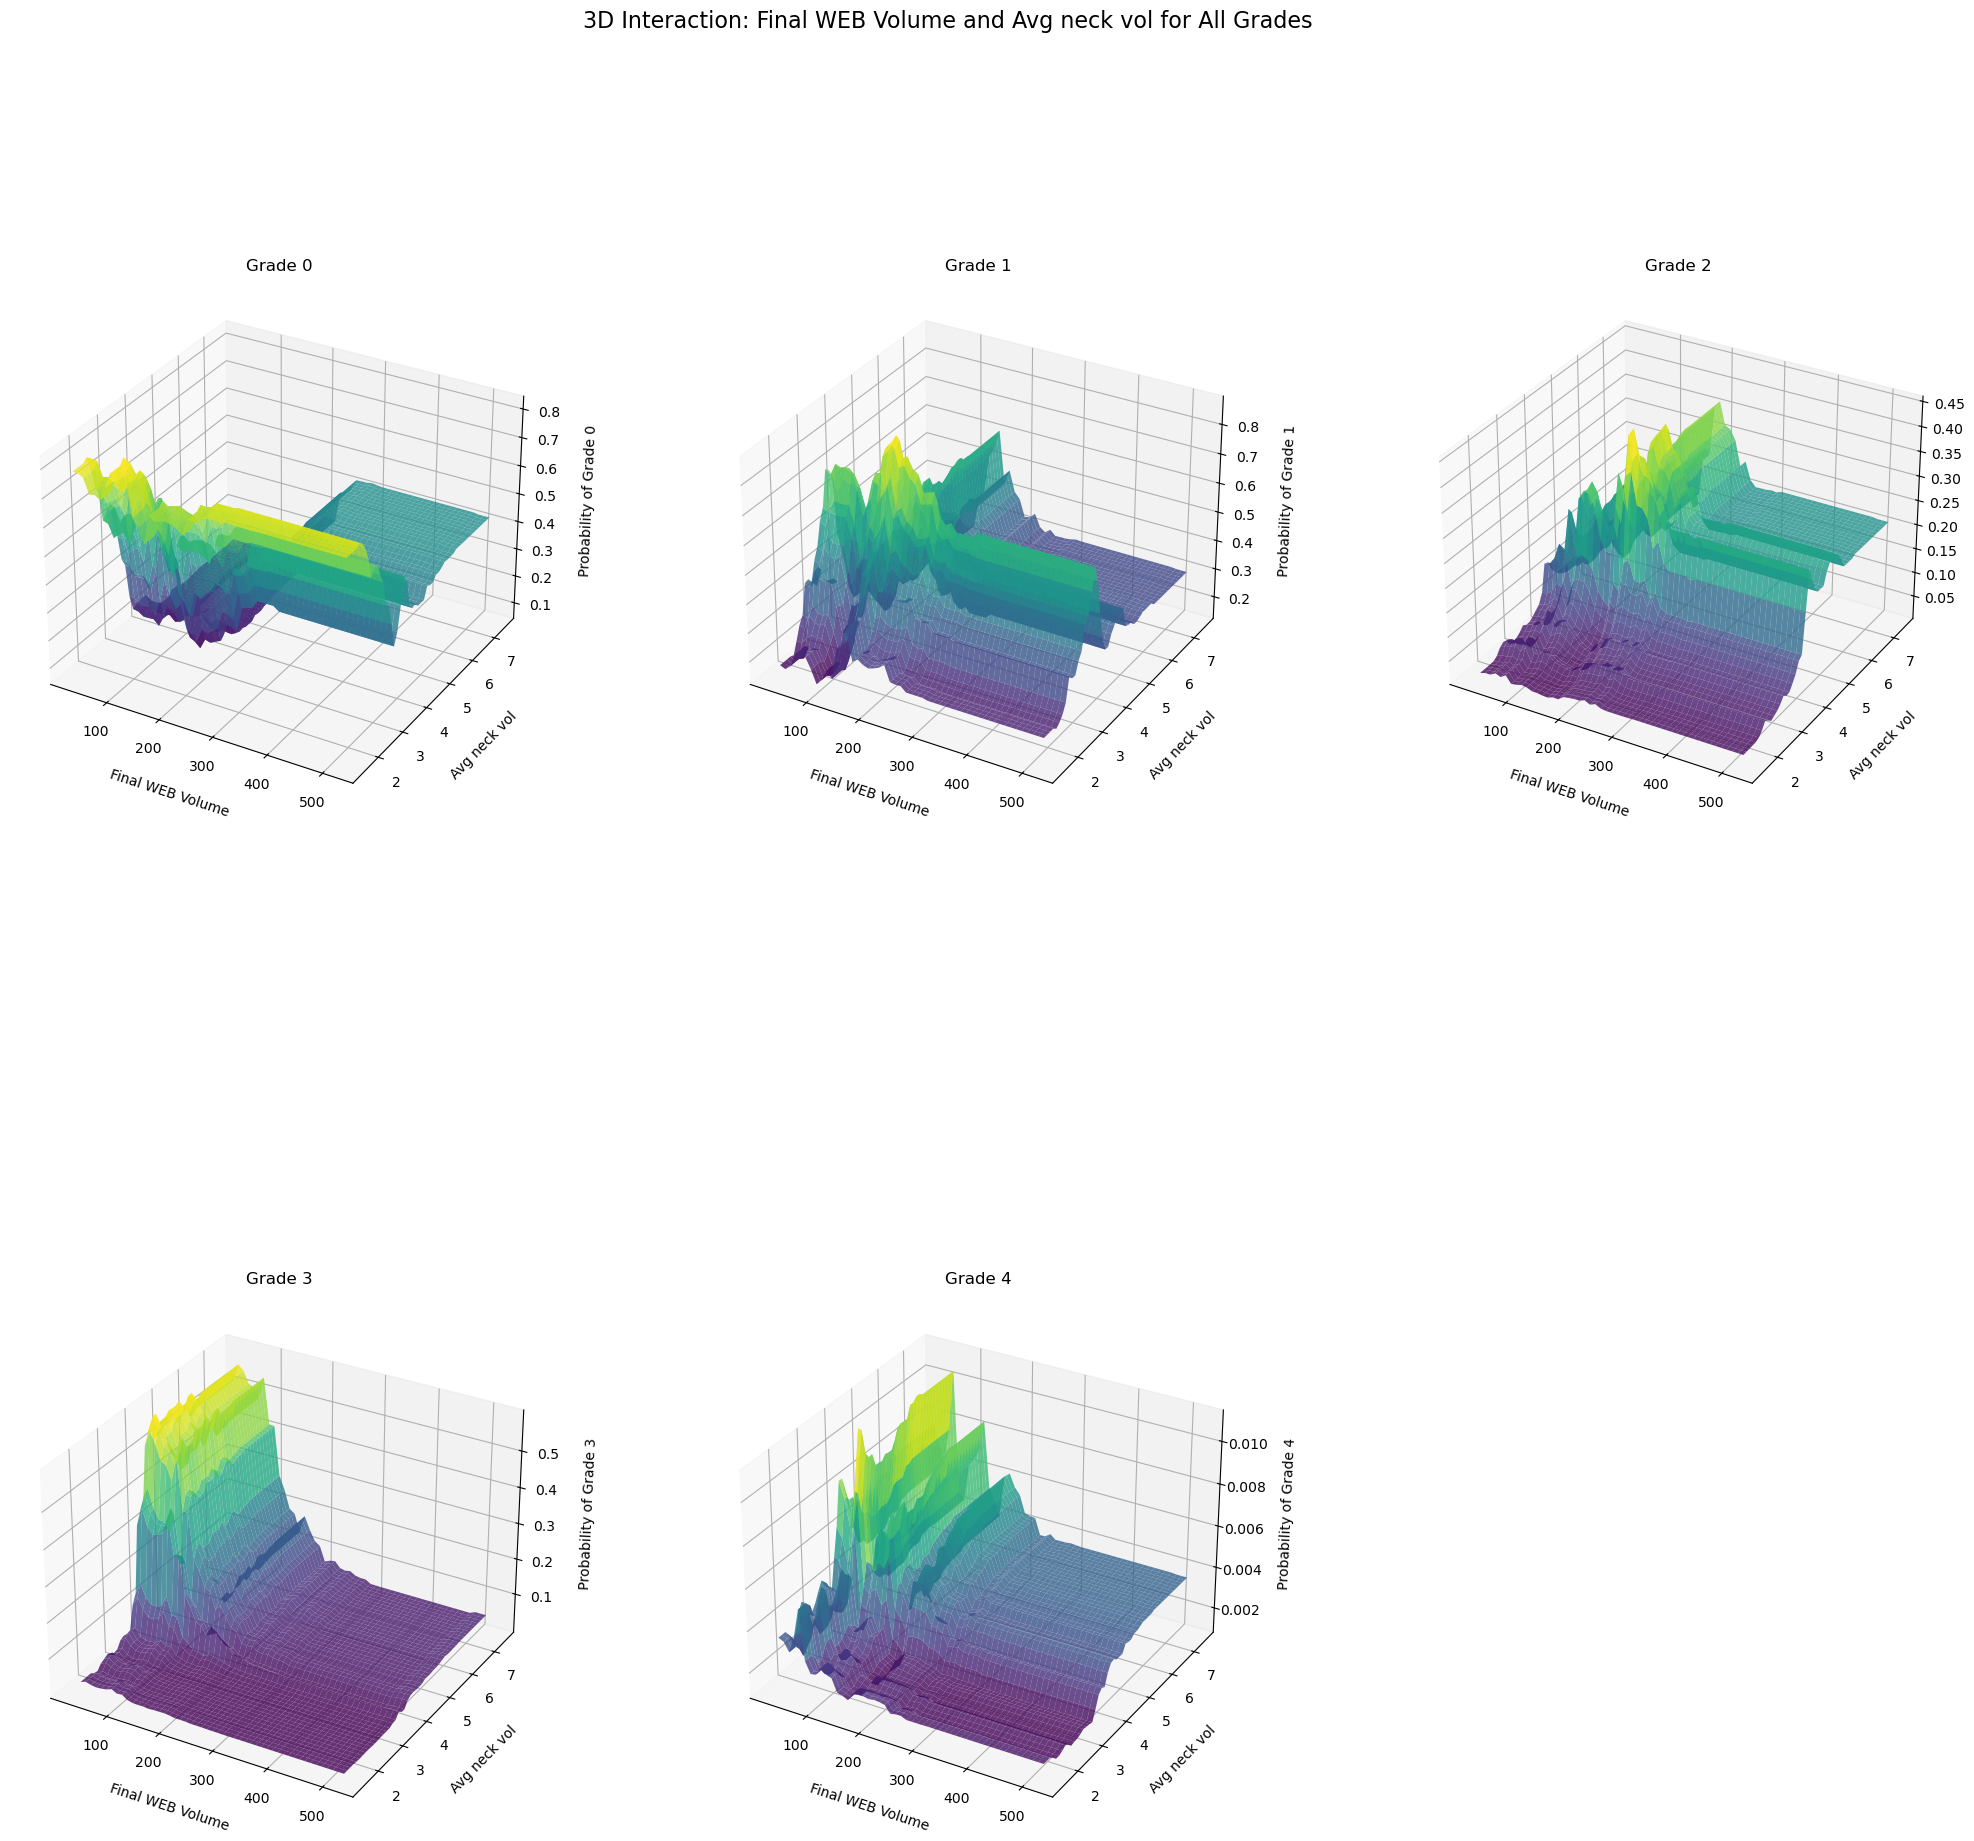

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Grid of `WEB Volume` and `Avg neck vol` (or any other two features)
web_volume_range = np.linspace(X["Final WEB Volume"].min(), X["Final WEB Volume"].max(), 50)
aneurysm_volume_range = np.linspace(X["Avg neck vol"].min(), X["Avg neck vol"].max(), 50)
web_volume, aneurysm_volume = np.meshgrid(web_volume_range, aneurysm_volume_range)

# Feature matrix
grid_data = np.zeros((web_volume.size, X.shape[1]))
grid_data[:, features.index("Final WEB Volume")] = web_volume.ravel()
grid_data[:, features.index("Avg neck vol")] = aneurysm_volume.ravel()

for feature_idx in range(X.shape[1]):
    if feature_idx not in [features.index("Final WEB Volume"), features.index("Avg neck vol")]:
        grid_data[:, feature_idx] = X.iloc[:, feature_idx].mean()

grid_data_df = pd.DataFrame(grid_data, columns=features)

model = models['XGBoost']  # or 'Random Forest' for Random Forest model
n_classes = len(np.unique(y)) 

# Plot
fig = plt.figure(figsize=(25, 22))

for class_idx in range(n_classes):
    # Predict probabilities for the current class
    probs = model.predict_proba(grid_data_df)[:, class_idx]  
    probs = probs.reshape(web_volume.shape)

    ax = fig.add_subplot(2, (n_classes + 1) // 2, class_idx + 1, projection='3d')
    surf = ax.plot_surface(web_volume, aneurysm_volume, probs, cmap="viridis", alpha=0.8)

    ax.set_xlabel("Final WEB Volume", labelpad=10)
    ax.set_ylabel("Avg neck vol", labelpad=10)
    ax.set_zlabel(f"Probability of Grade {class_idx}", labelpad=10)
    ax.set_title(f"Grade {class_idx}", fontsize=12)

plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.suptitle("3D Interaction: Final WEB Volume and Avg neck vol for All Grades", fontsize=16)
plt.show()


## Causal/Counterfactual Analysis for WAVe ratio and Procedural Features

##### WAVe Counterfactual Analysis

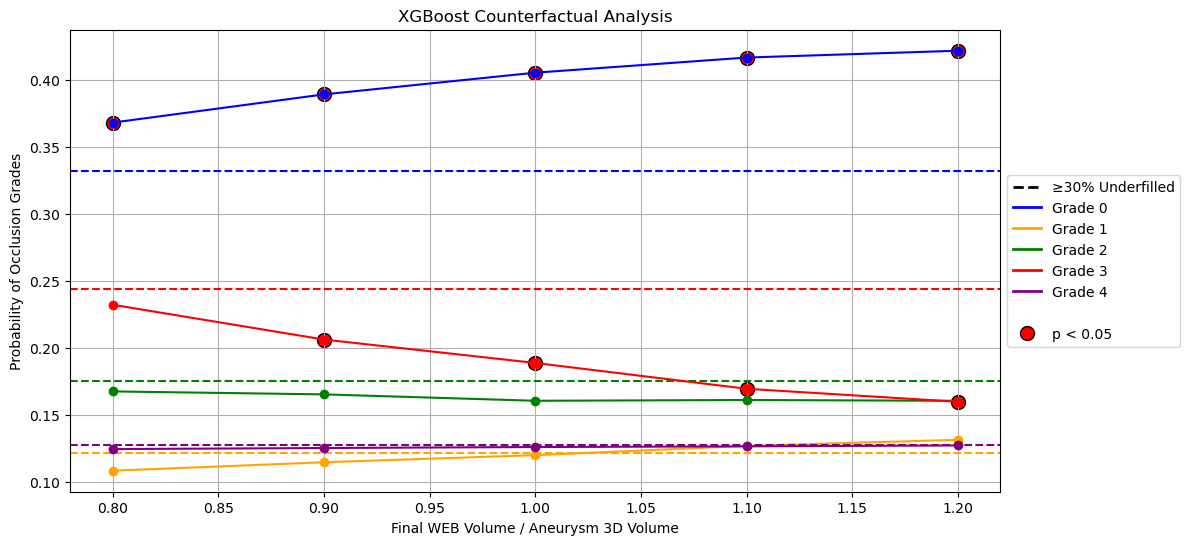

Baseline Probabilities (≥30% Underfilled Cases):
         Baseline Probability
Grade 0              0.331712
Grade 1              0.121536
Grade 2              0.175279
Grade 3              0.243802
Grade 4              0.127672

Probability Changes Across Overfill Ratios:

Grade 0:
     Probability Grade 0
0.8             0.368044
0.9             0.389121
1.0             0.405335
1.1             0.416624
1.2             0.421723

Grade 1:
     Probability Grade 1
0.8             0.108167
0.9             0.114497
1.0             0.119792
1.1             0.126708
1.2             0.131249

Grade 2:
     Probability Grade 2
0.8             0.167373
0.9             0.165162
1.0             0.160384
1.1             0.160961
1.2             0.160361

Grade 3:
     Probability Grade 3
0.8             0.232088
0.9             0.206101
1.0             0.188631
1.1             0.169340
1.2             0.159647

Grade 4:
     Probability Grade 4
0.8             0.124328
0.9             0.125118
1

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Overfilling ratios to test
overfill_ratios = [0.8, 0.9, 1.0, 1.1, 1.2]  # Underfill (80%, 90%), Balanced (100%), Overfill (110%, 120%)

# WAVe or Underfill ratio in the original dataset
synthetic_df['Underfill_Ratio'] = synthetic_df['Final WEB Volume'] / synthetic_df['Aneurysm 3D Volume']


underfilled_cases = synthetic_df[synthetic_df['Underfill_Ratio'] < 0.7].copy() # filter WAVe < 0.7

# Baseline occlusion probabilities for underfilled aneurysms
y_proba_baseline = best_xgb.predict_proba(underfilled_cases[features])
proba_df_baseline = pd.DataFrame(y_proba_baseline, columns=[f"Grade {i}" for i in range(5)])

probability_distributions = {}
baseline_probabilities = {grade: proba_df_baseline[grade] for grade in [f"Grade {i}" for i in range(5)]}

baseline_probs = {grade: baseline_probabilities[grade].mean() for grade in baseline_probabilities}

probability_changes = {grade: {} for grade in baseline_probabilities}
p_values = {grade: {} for grade in baseline_probabilities}

for ratio in overfill_ratios:
    # Counterfactual version 
    counterfactual_cases = underfilled_cases.copy()
    counterfactual_cases['Final WEB Volume'] = counterfactual_cases['Aneurysm 3D Volume'] * ratio  # Scale WEB Volume
    
    # Occlusion probabilities for counterfactual cases
    y_proba_counterfactual = best_xgb.predict_proba(counterfactual_cases[features])
    
    proba_df_counterfactual = pd.DataFrame(y_proba_counterfactual, columns=[f"Grade {i}" for i in range(5)])
    proba_df_counterfactual['Overfill Ratio'] = ratio  # Label with overfill ratio
    
    for grade in baseline_probabilities:
        probability_distributions[(ratio, grade)] = proba_df_counterfactual[grade]
        probability_changes[grade][ratio] = probability_distributions[(ratio, grade)].mean()

        # Paired t-test to compare baseline vs. counterfactual
        try:
            t_stat, p_value = ttest_rel(baseline_probabilities[grade], probability_distributions[(ratio, grade)])
        except ValueError:  
            p_value = 1.0  

        p_values[grade][ratio] = p_value

# Plot
probability_changes_df = {grade: pd.DataFrame.from_dict(probability_changes[grade], orient='index', columns=[f'Probability {grade}']) for grade in baseline_probabilities}
p_values_df = {grade: pd.DataFrame.from_dict(p_values[grade], orient='index', columns=['p_value']) for grade in baseline_probabilities}

grade_colors = {
    "Grade 0": "blue",
    "Grade 1": "orange",
    "Grade 2": "green",
    "Grade 3": "red",
    "Grade 4": "purple"
}

plt.figure(figsize=(12, 6))

for grade in baseline_probabilities:
    color = grade_colors[grade]  
    plt.plot(probability_changes_df[grade].index, probability_changes_df[grade][f'Probability {grade}'], marker='o', linestyle='-', label=grade, color=color)
    
    plt.axhline(y=baseline_probs[grade], color=color, linestyle='--')

    for ratio in overfill_ratios:
        if p_values[grade][ratio] < 0.05:
            plt.scatter(ratio, probability_changes_df[grade].loc[ratio, f'Probability {grade}'], color='red', s=100, edgecolors='black')

# Legend 
handles = [
    plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label="≥30% Underfilled"),
]
handles += [plt.Line2D([0], [0], color=color, linewidth=2, label=grade) for grade, color in grade_colors.items()]
handles.append(plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=0))  # Empty line for spacing
handles.append(plt.Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=10, markeredgecolor='black', label="p < 0.05"))

plt.xlabel("Final WEB Volume / Aneurysm 3D Volume")
plt.ylabel("Probability of Occlusion Grades")
plt.title("XGBoost Counterfactual Analysis")

plt.legend(handles=handles, loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

print("Baseline Probabilities (≥30% Underfilled Cases):")
print(pd.DataFrame.from_dict(baseline_probs, orient='index', columns=['Baseline Probability']))

print("\nProbability Changes Across Overfill Ratios:")
for grade in baseline_probabilities:
    print(f"\n{grade}:")
    print(probability_changes_df[grade])

print("\nStatistical Significance (p-values):")
for grade in baseline_probabilities:
    print(f"\n{grade}:")
    print(p_values_df[grade])


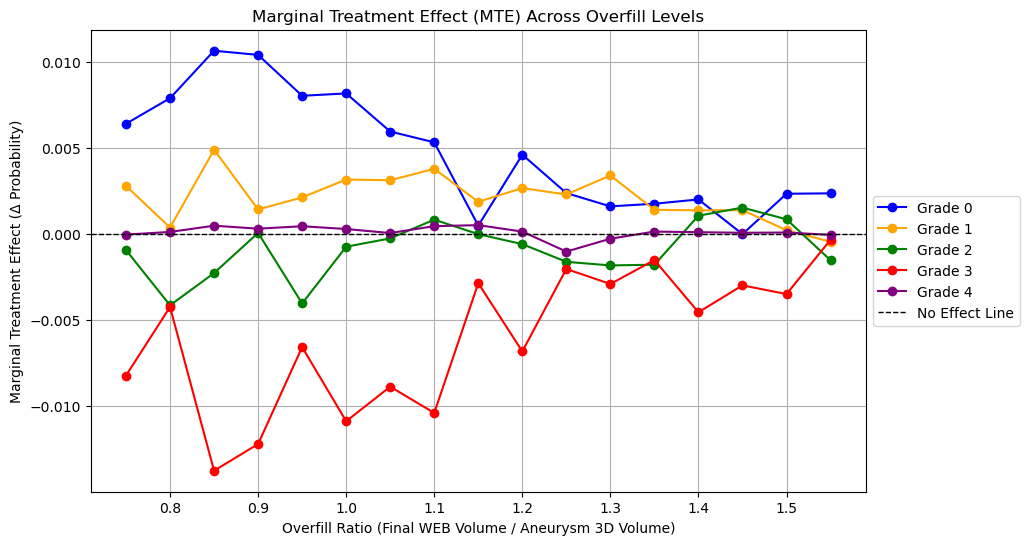


Marginal Treatment Effect (MTE) Across Overfill Ratios:

Grade 0:
      MTE Grade 0
0.75     0.006412
0.80     0.007898
0.85     0.010659
0.90     0.010417
0.95     0.008039
1.00     0.008175
1.05     0.005959
1.10     0.005330
1.15     0.000486
1.20     0.004612
1.25     0.002380
1.30     0.001606
1.35     0.001760
1.40     0.002008
1.45    -0.000007
1.50     0.002340
1.55     0.002364

Grade 1:
      MTE Grade 1
0.75     0.002796
0.80     0.000376
0.85     0.004901
0.90     0.001429
0.95     0.002127
1.00     0.003168
1.05     0.003124
1.10     0.003792
1.15     0.001872
1.20     0.002669
1.25     0.002297
1.30     0.003406
1.35     0.001405
1.40     0.001376
1.45     0.001390
1.50     0.000216
1.55    -0.000452

Grade 2:
      MTE Grade 2
0.75    -0.000935
0.80    -0.004148
0.85    -0.002272
0.90     0.000062
0.95    -0.004039
1.00    -0.000739
1.05    -0.000258
1.10     0.000834
1.15    -0.000010
1.20    -0.000591
1.25    -0.001619
1.30    -0.001828
1.35    -0.001787
1.40     0.00

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Overfill ratios
overfill_ratios = np.arange(0.7, 1.6, 0.05)  # 70% to 150% in 5% steps (granular)

# WAVE or underfill ratio calculation 
synthetic_df['Underfill_Ratio'] = synthetic_df['Final WEB Volume'] / synthetic_df['Aneurysm 3D Volume']

underfilled_cases = synthetic_df[synthetic_df['Underfill_Ratio'] < 0.7].copy()

# Baseline occlusion probabilities for underfilled aneurysms
y_proba_baseline = best_xgb.predict_proba(underfilled_cases[features])
proba_df_baseline = pd.DataFrame(y_proba_baseline, columns=[f"Grade {i}" for i in range(5)])

probability_distributions = {}
baseline_probabilities = {grade: proba_df_baseline[grade] for grade in [f"Grade {i}" for i in range(5)]}
probability_changes = {grade: {} for grade in baseline_probabilities}

for ratio in overfill_ratios:
    counterfactual_cases = underfilled_cases.copy()
    counterfactual_cases['Final WEB Volume'] = counterfactual_cases['Aneurysm 3D Volume'] * ratio
    
    y_proba_counterfactual = best_xgb.predict_proba(counterfactual_cases[features])
    proba_df_counterfactual = pd.DataFrame(y_proba_counterfactual, columns=[f"Grade {i}" for i in range(5)])
    
    for grade in baseline_probabilities:
        probability_distributions[(ratio, grade)] = proba_df_counterfactual[grade]
        probability_changes[grade][ratio] = probability_distributions[(ratio, grade)].mean()

# Marginal Treatment Effect (MTE) for each grade
mte_results = {grade: {} for grade in baseline_probabilities}

for i in range(1, len(overfill_ratios)):  
    prev_ratio, curr_ratio = overfill_ratios[i - 1], overfill_ratios[i]
    
    for grade in baseline_probabilities:
        mte_results[grade][curr_ratio] = (
            probability_changes[grade][curr_ratio] - probability_changes[grade][prev_ratio]
        )

# Plot
mte_df = {grade: pd.DataFrame.from_dict(mte_results[grade], orient='index', columns=[f'MTE {grade}']) for grade in baseline_probabilities}

plt.figure(figsize=(10, 6))
grade_colors = {
    "Grade 0": "blue",
    "Grade 1": "orange",
    "Grade 2": "green",
    "Grade 3": "red",
    "Grade 4": "purple"
}

for grade in baseline_probabilities:
    color = grade_colors[grade]
    plt.plot(mte_df[grade].index, mte_df[grade][f'MTE {grade}'], marker='o', linestyle='-', label=grade, color=color)

# Reference line at 0
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="No Effect Line")

plt.xlabel("Overfill Ratio (Final WEB Volume / Aneurysm 3D Volume)")
plt.ylabel("Marginal Treatment Effect (Δ Probability)")
plt.title("Marginal Treatment Effect (MTE) Across Overfill Levels")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

# Print MTE values
print("\nMarginal Treatment Effect (MTE) Across Overfill Ratios:")
for grade in baseline_probabilities:
    print(f"\n{grade}:")
    print(mte_df[grade])


##### Procedural features Counterfactual Analysis

C:\Users\shrin\AppData\Local\Temp\ipykernel_15116\1886948736.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_df = annot_df.applymap(lambda x: f"{x:.1f}%" if abs(x) >= 1 else "")


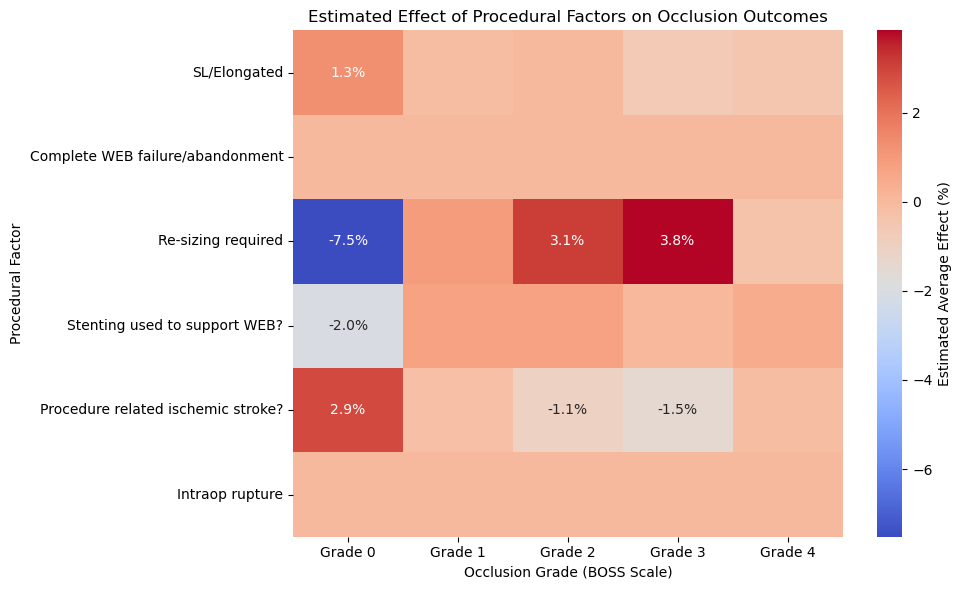

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Procedural features (excluding Circulation)
procedural_features = [
    'SL/Elongated', 'Complete WEB failure/abandonment', 'Re-sizing required',
    'Stenting used to support WEB?', 'Procedure related ischemic stroke?', 'Intraop rupture'
]

model = models['Random Forest']  # or 'XGBoost' for XGBoost model

# Calculate Average Treatment Effect (ATE) per feature
ate_results = {}
for feature in procedural_features:
    ate_per_class = []
    for target_class in np.unique(y):  
        # Baseline predictions without intervention
        baseline_preds = model.predict_proba(X)[:, target_class]
        
        # Counterfactual data where the current feature is set to 1
        X_counterfactual = X.copy()
        X_counterfactual[feature] = 1
        
        # Counterfactual predictions
        counterfactual_preds = model.predict_proba(X_counterfactual)[:, target_class]
        
        # Calculate ATE for the current class and feature
        ate = np.mean(counterfactual_preds - baseline_preds) * 100  # Convert to %
        ate_per_class.append(ate)
    
    # Store ATE 
    ate_results[feature] = ate_per_class

# Visualize
ate_df = pd.DataFrame(ate_results, index=[f'Grade {cls}' for cls in np.unique(y)]).T

annot_df = ate_df.copy()
annot_df = annot_df.applymap(lambda x: f"{x:.1f}%" if abs(x) >= 1 else "")

plt.figure(figsize=(10, 6))
sns.heatmap(ate_df, annot=annot_df, cmap="coolwarm", fmt="", cbar_kws={'label': 'Estimated Average Effect (%)'})
plt.title("Estimated Effect of Procedural Factors on Occlusion Outcomes")
plt.xlabel("Occlusion Grade (BOSS Scale)")
plt.ylabel("Procedural Factor")
plt.tight_layout()
plt.show()


                              Feature  Importance       Std
2                  Re-sizing required    0.000012  0.000006
0                        SL/Elongated    0.000004  0.000001
1    Complete WEB failure/abandonment    0.000000  0.000000
3       Stenting used to support WEB?    0.000000  0.000000
4  Procedure related ischemic stroke?    0.000000  0.000000
5                     Intraop rupture    0.000000  0.000000


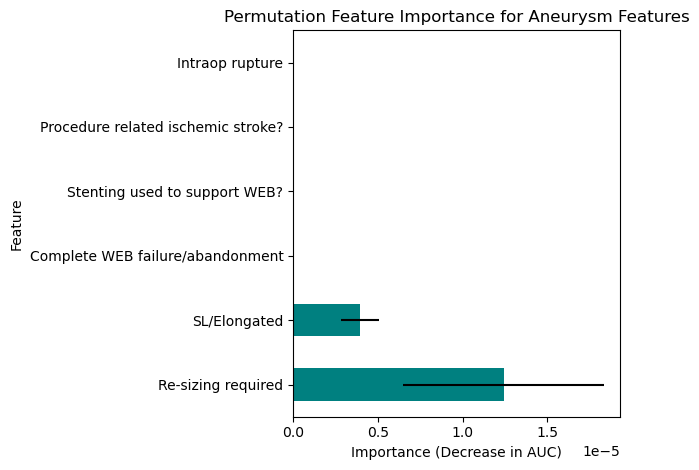

In [16]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd


# Permutational importance for procedural_features
perm_importance = permutation_importance(
    model,  
    X,  
    y,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc_ovr'
)


procedural_importance = {
    feature: perm_importance.importances_mean[X.columns.get_loc(feature)]
    for feature in procedural_features
}

# Visualize
importance_df = pd.DataFrame({
    'Feature': procedural_importance.keys(),
    'Importance': procedural_importance.values(),
    'Std': [perm_importance.importances_std[X.columns.get_loc(f)] for f in procedural_features]
}).sort_values(by='Importance', ascending=False)

print(importance_df)

importance_df.plot.barh(
    x='Feature', y='Importance', xerr='Std', legend=False, color='teal'
)
plt.title("Permutation Feature Importance for Aneurysm Features")
plt.xlabel("Importance (Decrease in AUC)")
plt.tight_layout()
plt.show()


## Privacy Analysis  

##### Distance-to-closest Record (DCR) using Euclidean Distance

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

original_data = original_df[features].dropna()
synthetic_data = synthetic_df[features]

#  Euclidean distances
distances = cdist(synthetic_data, original_data, metric='euclidean')  # Synthetic to original distances
min_distances = np.min(distances, axis=1)  # Minimum distance for each synthetic point to original

print(f"Mean Euclidean Distance (Synthetic -> Original): {np.mean(min_distances):.4f}")
print(f"Median Euclidean Distance (Synthetic -> Original): {np.median(min_distances):.4f}")
print(f"Min Euclidean Distance (Synthetic -> Original): {np.min(min_distances):.4f}")
print(f"Max Euclidean Distance (Synthetic -> Original): {np.max(min_distances):.4f}")

# ORIGINAL-to-original distances
original_distances = cdist(original_data, original_data, metric='euclidean')
np.fill_diagonal(original_distances, np.inf)  
min_original_distances = np.min(original_distances, axis=1)

print(f"Mean Euclidean Distance (Original -> Original): {np.mean(min_original_distances):.4f}")
print(f"Median Euclidean Distance (Original -> Original): {np.median(min_original_distances):.4f}")
print(f"Min Euclidean Distance (Original -> Original): {np.min(min_original_distances):.4f}")
print(f"Max Euclidean Distance (Original -> Original): {np.max(min_original_distances):.4f}")


Mean Euclidean Distance (Synthetic -> Original): 18.2262
Median Euclidean Distance (Synthetic -> Original): 14.7507
Min Euclidean Distance (Synthetic -> Original): 1.9282
Max Euclidean Distance (Synthetic -> Original): 79.9110
Mean Euclidean Distance (Original -> Original): 23.2178
Median Euclidean Distance (Original -> Original): 14.1407
Min Euclidean Distance (Original -> Original): 3.5302
Max Euclidean Distance (Original -> Original): 113.4804


In [29]:
print(f"5th Percentile (Synthetic -> Original): {np.percentile(min_distances, 5):.4f}")
print(f"5th Percentile (Original -> Original): {np.percentile(min_original_distances, 5):.4f}")


5th Percentile (Synthetic -> Original): 4.7610
5th Percentile (Original -> Original): 6.2730


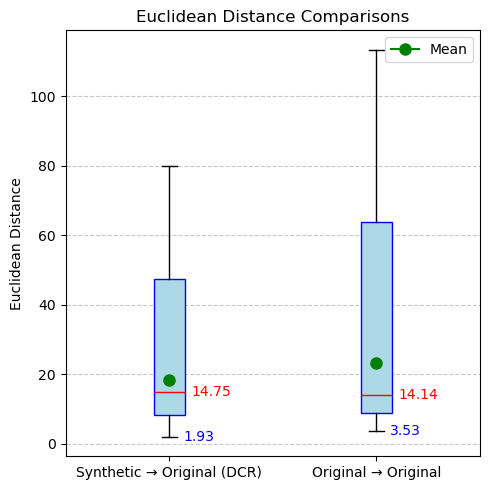

In [ ]:
import matplotlib.pyplot as plt

# Plot 
distances = {
    "Synthetic → Original (DCR)": {
        "Mean": 18.2262,
        "Median": 14.7507,
        "Min": 1.9282,
        "Max": 79.9110
    },
    "Original → Original": {
        "Mean": 23.2178,
        "Median": 14.1407,
        "Min": 3.5302,
        "Max": 113.4804
    }
}

box_data = [
    [distances["Synthetic → Original (DCR)"]["Min"], 
     distances["Synthetic → Original (DCR)"]["Median"], 
     distances["Synthetic → Original (DCR)"]["Max"]],
    
    [distances["Original → Original"]["Min"], 
     distances["Original → Original"]["Median"], 
     distances["Original → Original"]["Max"]]
]

means = [
    distances["Synthetic → Original (DCR)"]["Mean"], 
    distances["Original → Original"]["Mean"]
]


fig, ax = plt.subplots(figsize=(5, 5))
bp = ax.boxplot(box_data, vert=True, patch_artist=True, labels=["Synthetic → Original (DCR)", "Original → Original"], 
                boxprops=dict(facecolor='lightblue', color='blue'), 
                medianprops=dict(color='red'))

for i, mean in enumerate(means):
    ax.plot(i + 1, mean, marker="o", markersize=8, color="green", label="Mean" if i == 0 else "")

for i, label in enumerate(["Synthetic → Original (DCR)", "Original → Original"]):
    median = distances[label]["Median"]
    min_val = distances[label]["Min"]
    ax.annotate(f"{median:.2f}", xy=(i + 1, median), xytext=(16, 0),  # Adjusted xytext for median
                textcoords="offset points", fontsize=10, color="red", ha="left", va="center")
    ax.annotate(f"{min_val:.2f}", xy=(i + 1, min_val), xytext=(10, 0),
                textcoords="offset points", fontsize=10, color="blue", ha="left", va="center")

ax.legend(loc="upper right")

ax.set_title("Euclidean Distance Comparisons")
ax.set_ylabel("Euclidean Distance")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
